<a href="https://colab.research.google.com/github/dariashcherbakovaaa/pet-projects/blob/main/H3_AB_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание домашки

1. Сгенерировать 10 000 пользователей с помощью
UUID4;

2. С вероятностью 10% назначить пользователям
факт совершения некоторого действия;

3. Распределить пользователей 10 000 раз по
контрольной и тестовой группе. Для каждой
итерации - с новой солью. В качестве hash-функции
использовать md5.
4. Для каждой итерации оценить значимость
отличия конверсии в исходное действие. В качестве
p_value взять 0.05;

5. Построить распределение полученных 10 000
p_value на графике. Какое распределение
получилось?

6. Проверить соответствие полученного
распределения с равномерным с помощью теста
Колмогорова-Смирнова;

7. Сделать выводы.

In [ ]:
pip install statsmodels

In [ ]:
import pandas as pd
import numpy as np

import uuid
import hashlib

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.proportion import proportions_chisquare
from scipy.stats import chi2_contingency
from scipy.stats import ks_1samp, uniform
import warnings
warnings.filterwarnings("ignore")

###  Генерируем данные с 10% пользователей, которые активировались

In [ ]:
users = [str(uuid.uuid4()) for _ in range(10_000)]
df = pd.DataFrame({'user_id':users, 'action':0})
df.loc[df.sample(frac=0.1).index, 'action'] = 1
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(f'DB size: {df.shape}')
df.sample(20)

DB size: (10000, 2)


,user_id,action
2552,451320ba-2090-4139-84e9-b4ee153c48ed,0
3813,5500a0af-2fe3-4ba3-b453-01b9a7388c9b,0
9830,75a8cefd-1fc0-47e6-bceb-261798588440,0
7471,6a868351-ec78-4ed5-b2e2-1612b4af7e0c,0
9077,42cc369a-9bec-41b2-898d-58c35ea4f23b,0
8881,55c3bcea-c4a8-4da3-ad1a-7cbbef5008ac,0
2060,1a5b67b3-97d0-4d6d-9fe6-0a73d3e5b5ae,0
3122,c35c4896-d6a9-42f0-aa39-5323e72b3ea6,0
4992,08f9e173-e23f-4f21-b292-2460d350e4fb,0
3891,5e13132a-792e-400f-bcb0-16a4c9d9de09,0


In [ ]:
def hash_md5(user_id, salt):
    hash_value = hashlib.md5(f"{user_id}{salt}".encode()).hexdigest()
    hash_v = int(hash_value, 16) % 100
    return 'A' if hash_v < 50 else 'B'

### Сплиттуем по группам по солям и считаем стат.разничу между группами

* Для каждой итерации оценить значимость отличия конверсии в исходное действие. В качестве p_value взять 0.05;

Т.к. у нас бинарная переменная (доли), то мы можем применить Хи-квадрат

**H0**: конвесрии (доли) в группах равны

**H1**: конвесрии (доли) в группах не равны

In [ ]:
iterations =  10_000
alpha = 0.05

experiments = []

for i in range(iterations):
    salt = str(uuid.uuid4())
    group_labels = df['user_id'].apply(lambda user: hash_md5(user, salt))

    cr = df.groupby(group_labels)['action'].agg(['sum', 'count'])
    cr['not_converted'] = cr['count'] - cr['sum']
    contingency_table = cr[['sum', 'not_converted']].values
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    experiments.append(p_value)

df_experiments = pd.DataFrame(experiments, columns=['p_val'])
df_experiments.head(10)

,p_val
0,0.307711
1,0.386105
2,0.368112
3,0.930936
4,0.320535
5,0.048456
6,0.650247
7,0.459295
8,0.769267
9,0.552957


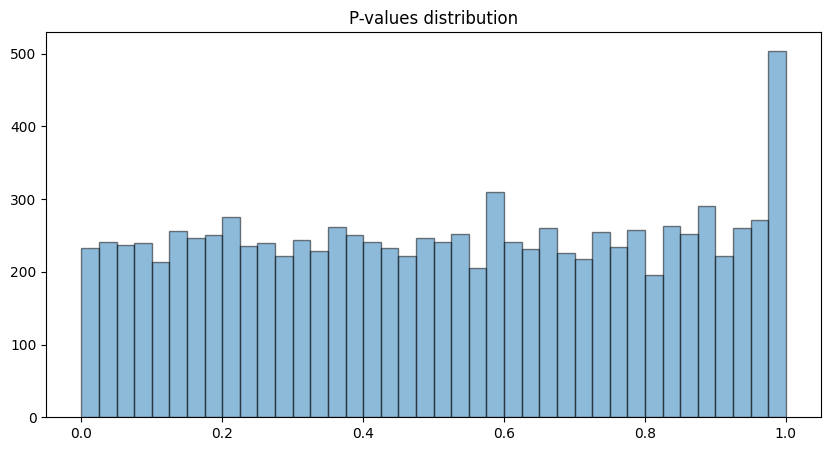

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(df_experiments['p_val'], bins=40, edgecolor='black', alpha=0.5)

plt.title("P-values distribution")
plt.show()


### Колмогоров-Смирнов

In [ ]:
ks_statistic, p_value_ks = ks_1samp(df_experiments['p_val'], uniform.cdf)

print(f"KS statistic: {ks_statistic}")
print(f"p-value: {p_value_ks}")

KS statistic: 0.03363779340406692
p-value: 2.890275089943649e-10


### **Выводы**

Мы провели сплитование пользователей на контрольную и тестовую группы. С помощью хи-квадрата мы проверили статистическую разницу между группами в контексте конверсий. Проверили распределие p-value.

*   Из графика мы видим небольшое смещение вправо в распределении p-values. Следовательно, мы не можем отвергнуть H0: конвесрии (доли) в группах равны. Т.е. сплитование не подвергло долю конверсий значимому эффекту
*   Согласно тесту на нормальность распределения, мы не можем принять H0, наше распределние p-values отклоняется от равномерного, не является случайным.
* Между контрольной и тестовой группой нет различий, соотвественно, мы не наблюдаем статистически-значимые эффеткы.



### **пробуем с statsmodels**

In [ ]:
iterations =  10_000
alpha = 0.05

for i in range(iterations):
    salt = str(uuid.uuid4())
    group_labels = df['user_id'].apply(lambda user: hash_md5(user, salt))

    cr = df.groupby(group_labels)['action'].agg(['sum', 'count'])
    stat, p_val, _ = proportions_chisquare(count=cr['sum'].values, nobs=cr['count'].values)
    experiments.append(p_val)

df_experiments = pd.DataFrame(experiments, columns=['p_val'])
df_experiments

,p_val
0,1.000000
1,1.000000
2,1.000000
3,1.000000
4,1.000000
...,...
10015,0.893922
10016,0.163449
10017,0.862381
10018,0.631227


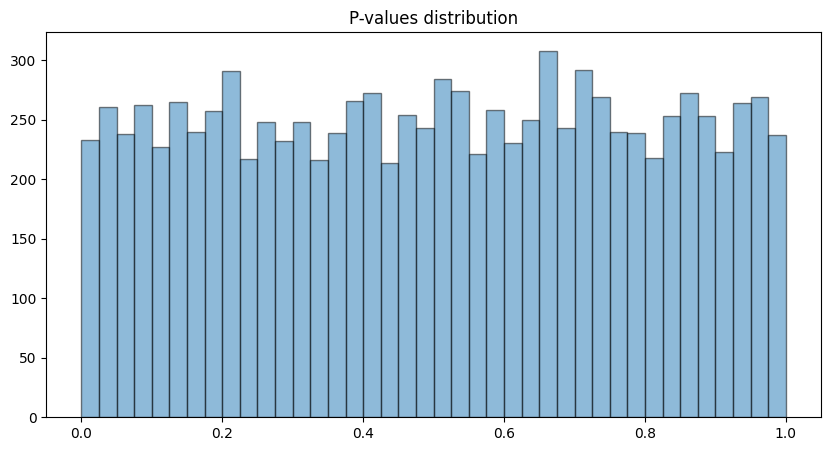

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(df_experiments['p_val'], bins=40, edgecolor='black', alpha=0.5)

plt.title("P-values distribution")
plt.show()


In [ ]:
ks_statistic, p_value_ks = ks_1samp(df_experiments['p_val'], uniform.cdf)

print(f"KS statistic: {ks_statistic}")
print(f"p-value: {p_value_ks}")

KS statistic: 0.009803857262664528
p-value: 0.28863835916544833
